https://www.kaggle.com/kmader/vae-to-detect-anomalies-on-digits

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics

In [66]:
import numpy as np
import pandas as pd
import glob
from PIL import Image
from matplotlib.pyplot import imshow
import keras
from keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D

def get_images(path,resize = True):  
    img_array = []
    label_array=[]
    img_paths=[]
    fpaths = glob.glob(path, recursive=True)
    
    for fname in fpaths:
        img = Image.open(fname).convert('L')
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
        img_paths.append(fname)
        
        if 'good' in fname.split("/"):
            label_array.append(0)
        else:
            label_array.append(1)
            
    paths=np.array(img_paths)
    images = np.array(img_array)
    labels= np.array(label_array)
    return images,labels,paths

In [67]:
path_train = r"C:\Users\polit\OneDrive\Desktop\MVtec\bottle\train\**\*.*"
path_test = r"C:\Users\polit\OneDrive\Desktop\MVtec\bottle\test\**\*.*"
path_cont_test = r"C:\Users\polit\OneDrive\Desktop\MVtec\bottle\test\contamination\*.*"

all_train,train_labels ,train_paths= get_images(path_train)
test ,test_labels,test_paths= get_images(path_test)
cont_test ,cont_test_labels,cont_test_paths= get_images(path_cont_test)

all_train = all_train.astype('float32') /255.
test = test.astype('float32') / 255.
cont_test = cont_test.astype('float32') / 255.

(train, val) = train_test_split(all_train, shuffle=False, train_size=0.8, random_state=1)
train = train.reshape(train.shape[0], train.shape[1], train.shape[2], 1)
val = val.reshape(val.shape[0], val.shape[1], val.shape[2], 1)
test = test.reshape(test.shape[0], test.shape[1], test.shape[2], 1)
cont_test = cont_test.reshape(cont_test.shape[0], cont_test.shape[1], cont_test.shape[2], 1)


In [68]:
batch_size = 256
original_shape = train.shape[1:]
original_dim = np.prod(original_shape)
latent_dim = 4
intermediate_dim = 128
final_dim = 64
epochs = 50
epsilon_std = 1.0

In [69]:
in_layer = Input(shape=original_shape)
x = Flatten()(in_layer)
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(final_dim, activation = 'relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_f = Dense(final_dim, activation='relu')
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

f_decoded = decoder_f(z)
h_decoded = decoder_h(f_decoded)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_img = Reshape(original_shape)(x_decoded_mean)

# instantiate VAE model
vae = Model(in_layer, x_decoded_img)

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          524416      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
______________________________________________________________________________________

In [70]:
vae.fit(train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val, None))

Epoch 1/50
1/1 [==============================] - 0s 198ms/step - loss: 2842.7473 - val_loss: 2667.4231
Epoch 2/50
1/1 [==============================] - 0s 20ms/step - loss: 2666.7373 - val_loss: 2282.3262
Epoch 3/50
1/1 [==============================] - 0s 17ms/step - loss: 2272.9514 - val_loss: 2256.7673
Epoch 4/50
1/1 [==============================] - 0s 18ms/step - loss: 2256.3074 - val_loss: 2105.7671
Epoch 5/50
1/1 [==============================] - 0s 17ms/step - loss: 2076.5884 - val_loss: 1945.4620
Epoch 6/50
1/1 [==============================] - 0s 17ms/step - loss: 1944.2570 - val_loss: 1835.2262
Epoch 7/50
1/1 [==============================] - 0s 18ms/step - loss: 1822.3108 - val_loss: 1757.9048
Epoch 8/50
1/1 [==============================] - 0s 17ms/step - loss: 1753.9435 - val_loss: 1724.7717
Epoch 9/50
1/1 [==============================] - 0s 19ms/step - loss: 1713.7338 - val_loss: 1694.0029
Epoch 10/50
1/1 [==============================] - 0s 18ms/step - loss: 

In [71]:
encoder = Model(in_layer, z_mean)
# display a 2D plot of the digit classes in the latent space
X_test_encoded = encoder.predict(test, batch_size=batch_size)

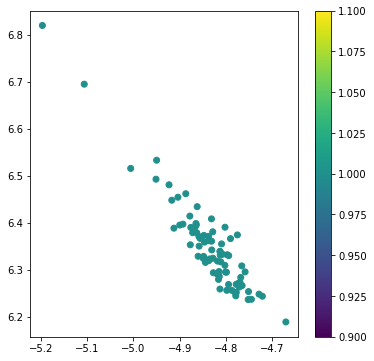

In [72]:
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c= test_labels)
plt.colorbar()
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 125 samples in 0.000s...
[t-SNE] Computed neighbors for 125 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 125 / 125
[t-SNE] Mean sigma: 0.041177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.976891
[t-SNE] KL divergence after 500 iterations: 0.167168


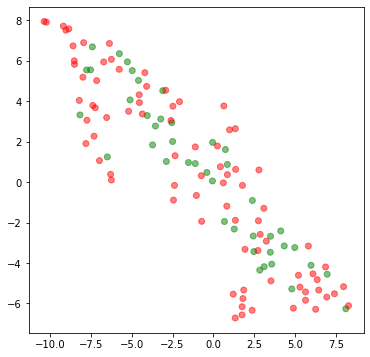

In [82]:
from sklearn.manifold import TSNE

anomaly_encoded = encoder.predict(test, batch_size=batch_size)
X_test_encoded = encoder.predict(val, batch_size=batch_size)

latent_space_tsne = TSNE(2, verbose = True, n_iter = 500)
xa_tsne = latent_space_tsne.fit_transform(np.concatenate([X_test_encoded[:, :], anomaly_encoded[:,:]],0))

plt.figure(figsize=(6, 6))
plt.scatter(xa_tsne[:,0], xa_tsne[:,1],
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)
plt.show()

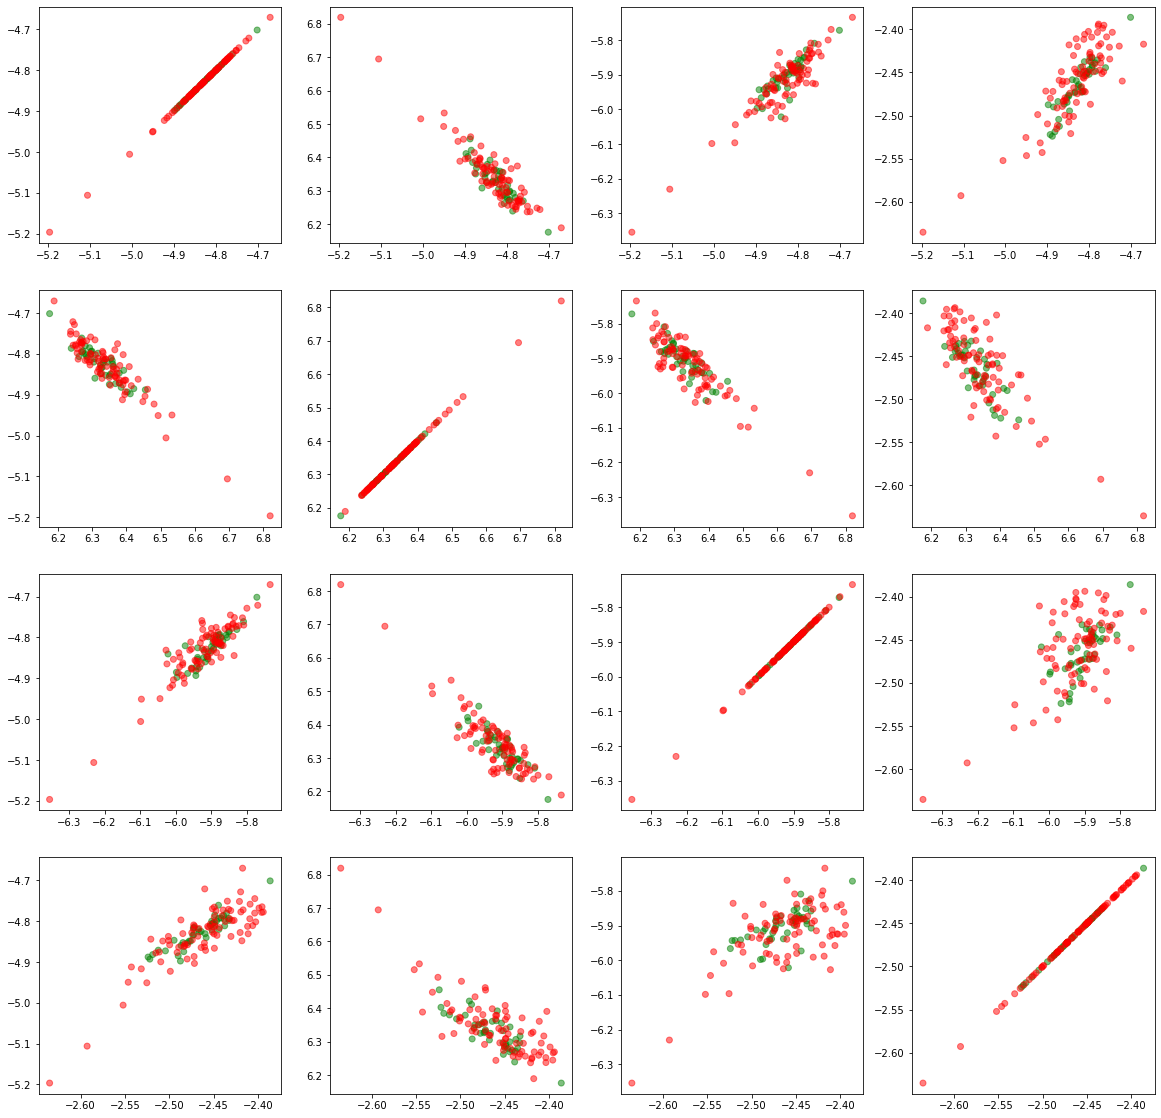

In [83]:
anomaly_encoded = encoder.predict(test, batch_size=batch_size)
fig, m_axs = plt.subplots(latent_dim,latent_dim, figsize=(latent_dim*5, latent_dim*5))
if latent_dim == 1:
    m_axs = [[m_axs]]
for i, n_axs in enumerate(m_axs, 0):
    for j, c_ax in enumerate(n_axs, 0):
        c_ax.scatter(np.concatenate([X_test_encoded[:, i], anomaly_encoded[:,i]],0), 
                           np.concatenate([X_test_encoded[:, j], anomaly_encoded[:,j]],0),
            c=(['g']*X_test_encoded.shape[0])+['r']*anomaly_encoded.shape[0], alpha = 0.5)

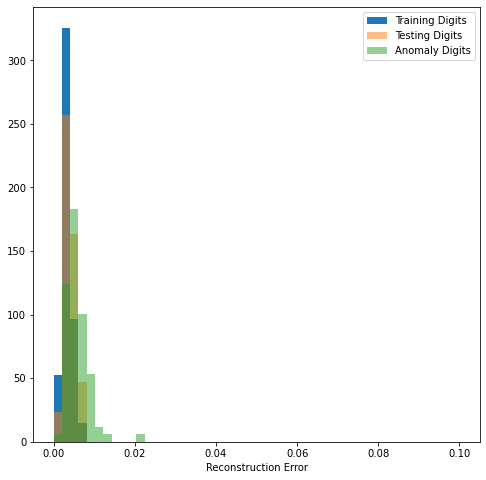

In [84]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = batch_size)), (1,2,3))
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(train), bins = np.linspace(0, .1, 50), label = 'Training Digits', density = True, alpha = 1.0)
ax1.hist(model_mse(val), bins = np.linspace(0, .1, 50), label = 'Testing Digits', density = True, alpha = 0.5)
ax1.hist(model_mse(test), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error');

Test data score -3.6883850980103587
Anomaly score -3.6990744290471667


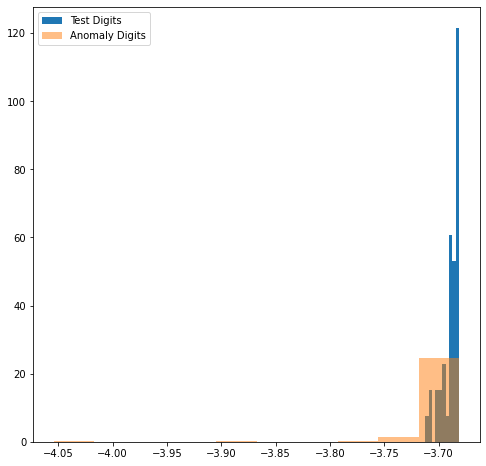

In [85]:
from sklearn.neighbors import KernelDensity
anomaly_encoded = encoder.predict(test, batch_size=batch_size)
X_test_encoded = encoder.predict(val, batch_size=batch_size)
kd = KernelDensity()
kd.fit(encoder.predict(train))
test_score = [kd.score(x.reshape(1, -1)) for x in X_test_encoded]
anom_score = [kd.score(x.reshape(1, -1)) for x in anomaly_encoded]
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(test_score, label = 'Test Digits', density = True, alpha = 1.0)
ax1.hist(anom_score, label = 'Anomaly Digits', density = True, alpha = 0.5)
ax1.legend()
print('Test data score', np.mean(test_score))
print('Anomaly score', np.mean(anom_score))

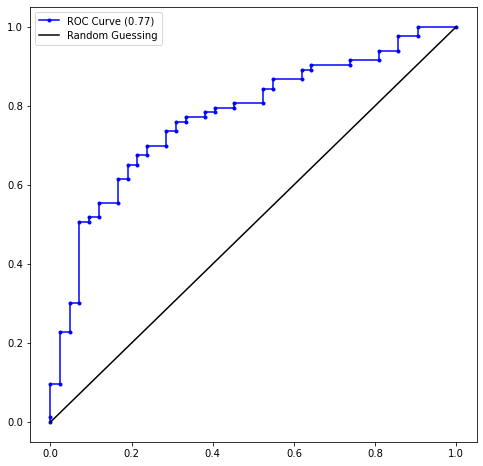

In [86]:
from sklearn.metrics import roc_auc_score, roc_curve
mse_score = np.concatenate([model_mse(val), model_mse(test)],0)
true_label = [0]*val.shape[0]+[1]*test.shape[0]
if roc_auc_score(true_label, mse_score)<0.5:
    mse_score *= -1
fpr, tpr, thresholds = roc_curve(true_label, mse_score)
auc_score = roc_auc_score(true_label, mse_score)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

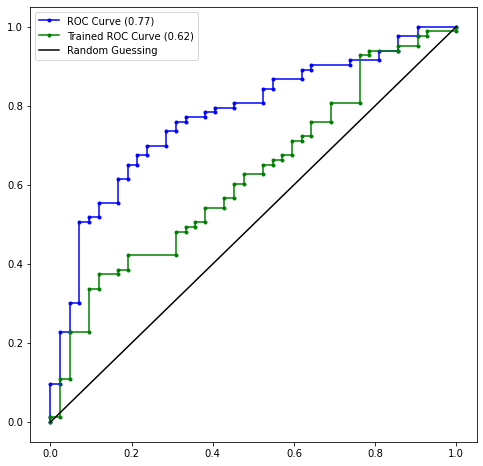

In [87]:
anom_exam = np.mean(xa_tsne[-3:,:],0)
mse_score_train = np.sqrt(np.square(xa_tsne[:,0]-anom_exam[0])+np.square(xa_tsne[:,1]-anom_exam[1]))
if roc_auc_score(true_label, mse_score_train)<0.5:
    mse_score_train *= -1

fpr_new, tpr_new, thresholds = roc_curve(true_label, mse_score_train)
auc_score_new = roc_auc_score(true_label, mse_score_train)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr_new, tpr_new, 'g.-', label = 'Trained ROC Curve (%2.2f)' %  auc_score_new)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();